# Strategy Optimization with Smoothing (the optimal frequency)

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("seaborn-v0_8")

In [7]:
# Version 3.0 (advanced Performance Optimization)

class ConBacktester():
    ''' Class for the vectorized backtesting of simple contrarian trading strategies.
    
    Attributes
    ============
    filepath: str
        local filepath of the dataset (csv-file)
    symbol: str
        ticker symbol (instrument) to be backtested
    start: str
        start date for data import
    end: str
        end date for data import
    tc: float
        proportional trading costs per trade
    
    
    Methods
    =======
    get_data:
        imports the data.
        
    test_strategy:
        prepares the data and backtests the trading strategy incl. reporting (wrapper).
        
    prepare_data:
        prepares the data for backtesting.
    
    run_backtest:
        runs the strategy backtest.
        
    plot_results:
        plots the cumulative performance of the trading strategy compared to buy-and-hold.
        
    optimize_strategy:
        backtests strategy for different parameter values incl. optimization and reporting (wrapper).
    
    find_best_strategy:
        finds the optimal strategy (global maximum) given the window parameter range.
        
    visualize_many:
        plots parameter values vs. performance. 
        
    print_performance:
        calculates and prints various performance metrics.
        
    '''    
    
    def __init__(self, filepath, symbol, start, end, tc):
        
        self.filepath = filepath
        self.symbol = symbol
        self.start = start
        self.end = end
        self.tc = tc
        self.results = None
        self.get_data()
        self.tp_year = (self.data.price.count() / ((self.data.index[-1] - self.data.index[0]).days / 365.25))
        
    def __repr__(self):
        return "ConBacktester(symbol = {}, start = {}, end = {})".format(self.symbol, self.start, self.end)
        
    def get_data(self):
        ''' Imports the data.
        '''
        raw = pd.read_csv(self.filepath, parse_dates = ["time"], index_col = "time")
        raw = raw[self.symbol].to_frame().fillna(method = "ffill") 
        raw = raw.loc[self.start:self.end].copy()
        raw.rename(columns={self.symbol: "price"}, inplace=True)
        raw["returns"] = np.log(raw.price / raw.price.shift(1))
        self.data = raw
        
    def test_strategy(self, window = 1):
        '''
        Prepares the data and backtests the trading strategy incl. reporting (Wrapper).
         
        Parameters
        ============
        window: int
            time window (number of bars) to be considered for the strategy.
        '''
        self.window = window
                                
        self.prepare_data(window)
        self.run_backtest()
        
        data = self.results.copy()
        data["creturns"] = data["returns"].cumsum().apply(np.exp)
        data["cstrategy"] = data["strategy"].cumsum().apply(np.exp)
        self.results = data
        
        self.print_performance()
    
    def prepare_data(self, window):
        ''' Prepares the Data for Backtesting.
        '''
        data = self.data.copy()
        data["roll_return"] = data["returns"].rolling(window).mean()
        data["position"] = -np.sign(data["roll_return"])
        self.results = data
    
    def run_backtest(self):
        ''' Runs the strategy backtest.
        '''
        
        data = self.results.copy()
        data["strategy"] = data["position"].shift(1) * data["returns"]
        data.dropna(inplace=True)
        
        # determine the number of trades in each bar
        data["trades"] = data.position.diff().fillna(0).abs()
        
        # subtract transaction/trading costs from pre-cost return
        data.strategy = data.strategy - data.trades * self.tc
        
        self.results = data
    
    def plot_results(self):
        '''  Plots the cumulative performance of the trading strategy compared to buy-and-hold.
        '''
        if self.results is None:
            print("Run test_strategy() first.")
        else:
            title = "{} | Window = {} | TC = {}".format(self.symbol, self.window, self.tc)
            self.results[["creturns", "cstrategy"]].plot(title=title, figsize=(12, 8))
            
    def optimize_strategy(self, window_range, metric = "Multiple"):
        '''
        Backtests strategy for different parameter values incl. Optimization and Reporting (Wrapper).
         
        Parameters
        ============
        window_range: tuple
            tuples of the form (start, end, step size).
        
        metric: str
            performance metric to be optimized (can be: "Multiple", "Sharpe", "Sortino", "Calmar", "Kelly")
        '''
        
        self.metric = metric
        
        if metric == "Multiple":
            performance_function = self.calculate_multiple
        elif metric == "Sharpe":
            performance_function = self.calculate_sharpe
        elif metric == "Sortino":
            performance_function = self.calculate_sortino
        elif metric == "Calmar": 
            performance_function = self.calculate_calmar
        elif metric == "Kelly": 
            performance_function = self.calculate_kelly_criterion
        
        windows = range(*window_range)
        
        performance = []
        for window in windows:
            self.prepare_data(window)
            self.run_backtest()
            performance.append(performance_function(self.results.strategy))
    
        self.results_overview =  pd.DataFrame(data = np.array(windows), columns = ["Windows"])
        self.results_overview["Performance"] = performance
        self.find_best_strategy()
        
    def find_best_strategy(self):
        ''' Finds the optimal strategy (global maximum) given the window parameter range.
        '''
        best = self.results_overview.nlargest(1, "Performance")
        window = best.Windows.iloc[0]
        perf = best.Performance.iloc[0]
        print("Windows: {} | {}: {}".format(window, self.metric, round(perf, 6))) 
        self.test_strategy(window)
        
    def visualize_many(self):
        ''' Plots parameter values vs. Performance.
        '''

        if self.results_overview is None:
            print("Run optimize_strategy() first.")
        else:
            self.results_overview.set_index("Windows", inplace = True)
            self.results_overview.plot(figsize = (12, 8))
            plt.title("Simple Contrarian Strategy | {} vs Windows".format(self.metric), fontsize = 15)
            plt.xlabel("Windows", fontsize = 15)
            plt.ylabel("{}".format(self.metric), fontsize = 15) 
            plt.show()   
            
    ############################## Performance ######################################
    
    def print_performance(self):
        ''' Calculates and prints various Performance Metrics.
        '''
        
        data = self.results.copy()
        strategy_multiple = round(self.calculate_multiple(data.strategy), 6)
        bh_multiple =       round(self.calculate_multiple(data.returns), 6)
        outperf =           round(strategy_multiple - bh_multiple, 6)
        cagr =              round(self.calculate_cagr(data.strategy), 6)
        ann_mean =          round(self.calculate_annualized_mean(data.strategy), 6)
        ann_std =           round(self.calculate_annualized_std(data.strategy), 6)
        sharpe =            round(self.calculate_sharpe(data.strategy), 6)
        sortino =           round(self.calculate_sortino(data.strategy), 6)
        max_drawdown =      round(self.calculate_max_drawdown(data.strategy), 6)
        calmar =            round(self.calculate_calmar(data.strategy), 6)
        max_dd_duration =   round(self.calculate_max_dd_duration(data.strategy), 6)
        kelly_criterion =   round(self.calculate_kelly_criterion(data.strategy), 6)
        
        print(100 * "=")
        print("SIMPLE CONTRARIAN STRATEGY | INSTRUMENT = {} | WINDOW = {}".format(self.symbol, self.window))
        print(100 * "-")
        #print("\n")
        print("PERFORMANCE MEASURES:")
        print("\n")
        print("Multiple (Strategy):         {}".format(strategy_multiple))
        print("Multiple (Buy-and-Hold):     {}".format(bh_multiple))
        print(38 * "-")
        print("Out-/Underperformance:       {}".format(outperf))
        print("\n")
        print("CAGR:                        {}".format(cagr))
        print("Annualized Mean:             {}".format(ann_mean))
        print("Annualized Std:              {}".format(ann_std))
        print("Sharpe Ratio:                {}".format(sharpe))
        print("Sortino Ratio:               {}".format(sortino))
        print("Maximum Drawdown:            {}".format(max_drawdown))
        print("Calmar Ratio:                {}".format(calmar))
        print("Max Drawdown Duration:       {} Days".format(max_dd_duration))
        print("Kelly Criterion:             {}".format(kelly_criterion))
        
        print(100 * "=")
        
    def calculate_multiple(self, series):
        return np.exp(series.sum())
    
    def calculate_cagr(self, series):
        return np.exp(series.sum())**(1/((series.index[-1] - series.index[0]).days / 365.25)) - 1
    
    def calculate_annualized_mean(self, series):
        return series.mean() * self.tp_year
    
    def calculate_annualized_std(self, series):
        return series.std() * np.sqrt(self.tp_year)
    
    def calculate_sharpe(self, series):
        if series.std() == 0:
            return np.nan
        else:
            return series.mean() / series.std() * np.sqrt(self.tp_year)
    
    def calculate_sortino(self, series):
        excess_returns = (series - 0)
        downside_deviation = np.sqrt(np.mean(np.where(excess_returns < 0, excess_returns, 0)**2))
        if downside_deviation == 0:
            return np.nan
        else:
            sortino = (series.mean() - 0) / downside_deviation * np.sqrt(self.tp_year)
            return sortino 
    
    def calculate_max_drawdown(self, series):
        creturns = series.cumsum().apply(np.exp)
        cummax = creturns.cummax()
        drawdown = (cummax - creturns)/cummax
        max_dd = drawdown.max()
        return max_dd
    
    def calculate_calmar(self, series):
        max_dd = self.calculate_max_drawdown(series)
        if max_dd == 0:
            return np.nan
        else:
            cagr = self.calculate_cagr(series)
            calmar = cagr / max_dd
            return calmar
    
    def calculate_max_dd_duration(self, series):
        creturns = series.cumsum().apply(np.exp)
        cummax = creturns.cummax()
        drawdown = (cummax - creturns)/cummax
    
        begin = drawdown[drawdown == 0].index
        end = begin[1:]
        end = end.append(pd.DatetimeIndex([drawdown.index[-1]]))
        periods = end - begin
        max_ddd = periods.max()
        return max_ddd.days
    
    def calculate_kelly_criterion(self, series):
        series = np.exp(series) - 1
        if series.var() == 0:
            return np.nan
        else:
            return series.mean() / series.var()
    
    ############################## Performance ######################################

In [3]:
low_f = pd.read_csv("intraday.csv", parse_dates = ["time"], index_col = "time")
low_f

,EURUSD
time,
2018-01-01 22:00:00+00:00,1.201205
2018-01-02 04:00:00+00:00,1.207055
2018-01-02 10:00:00+00:00,1.204440
2018-01-02 16:00:00+00:00,1.205800
2018-01-02 22:00:00+00:00,1.204690
...,...
2019-12-29 22:00:00+00:00,1.119920
2019-12-30 04:00:00+00:00,1.119940
2019-12-30 10:00:00+00:00,1.120095


In [4]:
high_f = pd.read_csv("one_minute.csv", parse_dates = ["time"], index_col = "time")
high_f

,EURUSD,GBPUSD,EURAUD
time,,,
2018-01-01 22:00:00,1.20071,1.35021,1.53836
2018-01-01 22:01:00,1.20068,1.35105,1.53829
2018-01-01 22:02:00,1.20073,1.35028,1.53834
2018-01-01 22:03:00,1.20072,1.35135,1.53833
2018-01-01 22:04:00,NaN,1.35098,NaN
...,...,...,...
2019-12-30 23:56:00,NaN,1.31136,1.59978
2019-12-30 23:57:00,1.12018,1.31126,1.60000
2019-12-30 23:58:00,NaN,1.31122,1.59994


In [5]:
high_f.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 737544 entries, 2018-01-01 22:00:00 to 2019-12-31 00:00:00
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   EURUSD  693492 non-null  float64
 1   GBPUSD  686852 non-null  float64
 2   EURAUD  710540 non-null  float64
dtypes: float64(3)
memory usage: 22.5 MB


In [7]:
high_f.fillna(method='ffill', inplace=True)

In [9]:
high_f.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 737544 entries, 2018-01-01 22:00:00 to 2019-12-31 00:00:00
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   EURUSD  737544 non-null  float64
 1   GBPUSD  737544 non-null  float64
 2   EURAUD  737544 non-null  float64
dtypes: float64(3)
memory usage: 22.5 MB


<Axes: xlabel='time'>

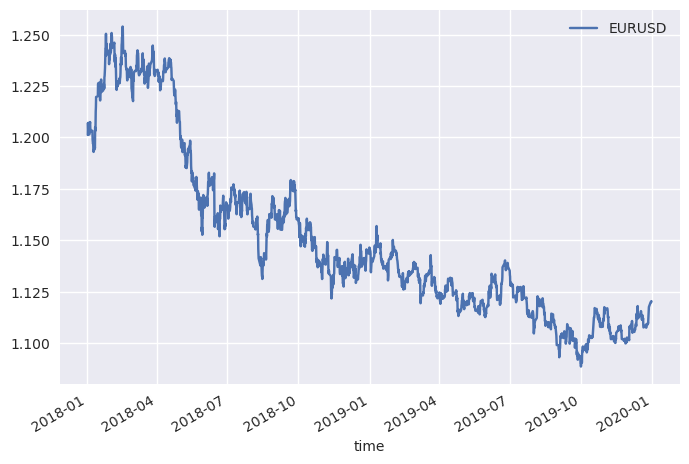

In [10]:
low_f.plot()

<Axes: xlabel='time'>

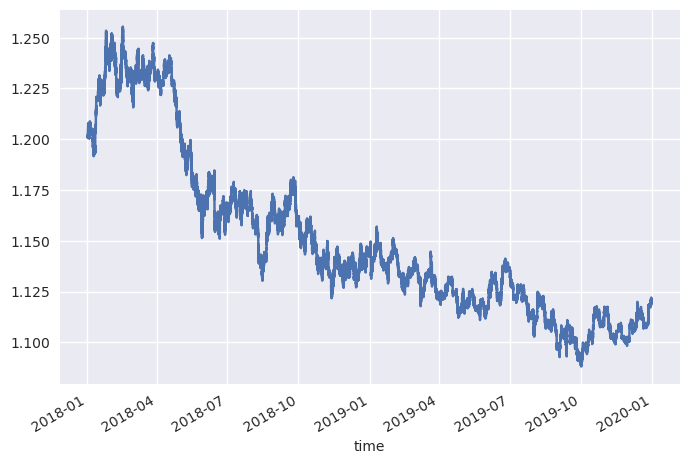

In [13]:
high_f.EURUSD.plot()

<Axes: xlabel='time'>

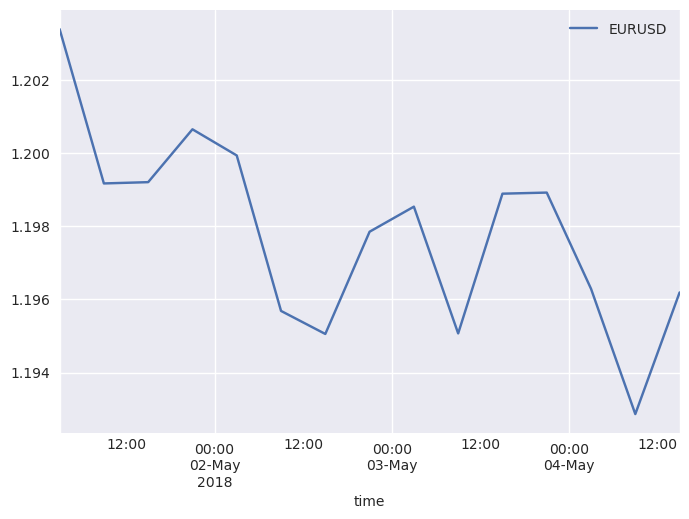

In [14]:
low_f.loc["2018-05-01":"2018-05-05"].plot()

<Axes: xlabel='time'>

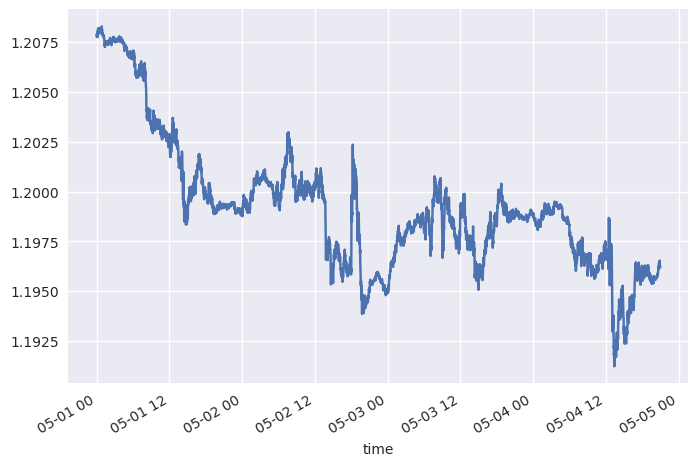

In [15]:
high_f.loc["2018-05-01":"2018-05-05", "EURUSD"].plot()

**Conclusion and open questions:**
- 1 minute data contains additional short-term price moves and volatility
- price volatility is a desirable attribute for trading, we can't make profits if prices don't move 
- more information is better than less information
- can we take advantage of the short-term volatility or it just (patternless) random noise?
- at least it doesn't hurt us, right?
- best contrarian strategy based on 1 minute data should be at least as good as the best one based on 6h data, right?

## How Trading Strategies are impacted by Random Noise (without costs)

In [16]:
# assumption of zero proportional zero costs

symbol = "EURUSD"
start = "2018-01-01"
end = "2019-12-31"
ptc = 0

### 6h data

In [17]:
tester1 = ConBacktester(filepath = "intraday.csv", symbol = symbol, start = start, end = end, tc = ptc)
tester1

ConBacktester(symbol = EURUSD, start = 2018-01-01, end = 2019-12-31)

In [18]:
tester1.optimize_strategy((1, 1001, 1), metric = "Multiple")

Windows: 44 | Multiple: 1.288223
SIMPLE CONTRARIAN STRATEGY | INSTRUMENT = EURUSD | WINDOW = 44
----------------------------------------------------------------------------------------------------
PERFORMANCE MEASURES:


Multiple (Strategy):         1.288223
Multiple (Buy-and-Hold):     0.913293
--------------------------------------
Out-/Underperformance:       0.37493


CAGR:                        0.13874
Annualized Mean:             0.12989
Annualized Std:              0.060266
Sharpe Ratio:                2.155286
Sortino Ratio:               3.346279
Maximum Drawdown:            0.057729
Calmar Ratio:                2.403288
Max Drawdown Duration:       81 Days
Kelly Criterion:             36.226556


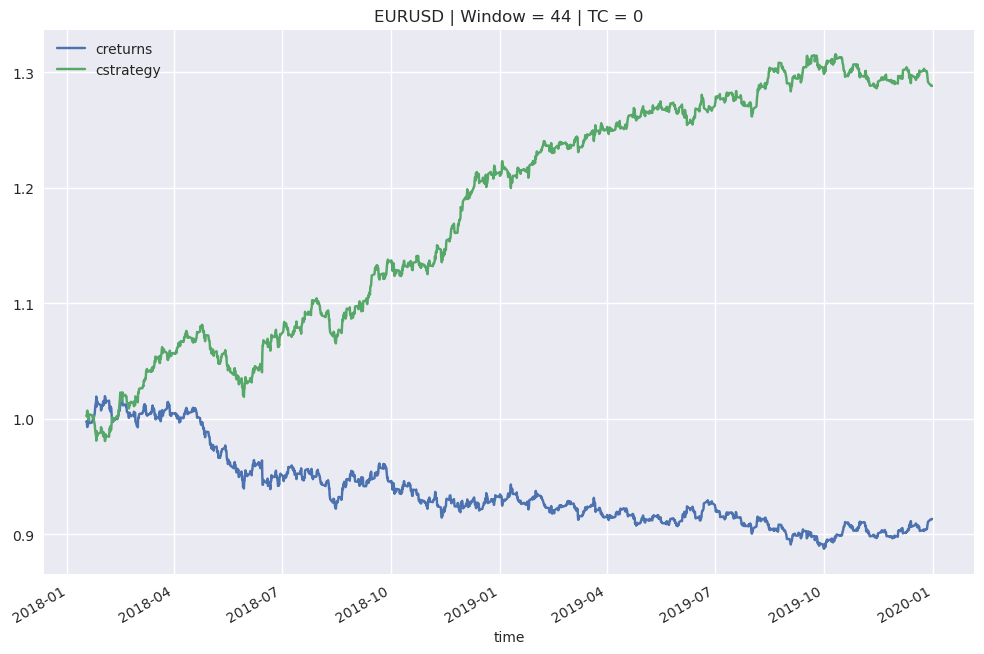

In [19]:
tester1.plot_results()

**Summary:**
- bar length (frequency/granularity): 6 hours
- decision/trading frequency: 6 hours
- decisions based on the performance of the most recent 264 hours (44 * 6h)

### 1 minute data

In [20]:
tester2 = ConBacktester(filepath = "one_minute.csv", symbol = symbol, start = start, end = end, tc = ptc)
tester2

ConBacktester(symbol = EURUSD, start = 2018-01-01, end = 2019-12-31)

In [21]:
window = 44
hours = 6
minutes = 60

In [22]:
tester2.test_strategy(window = window * hours * minutes)

SIMPLE CONTRARIAN STRATEGY | INSTRUMENT = EURUSD | WINDOW = 15840
----------------------------------------------------------------------------------------------------
PERFORMANCE MEASURES:


Multiple (Strategy):         1.304608
Multiple (Buy-and-Hold):     0.913462
--------------------------------------
Out-/Underperformance:       0.391146


CAGR:                        0.145928
Annualized Mean:             0.136336
Annualized Std:              0.067859
Sharpe Ratio:                2.009107
Sortino Ratio:               2.852712
Maximum Drawdown:            0.059655
Calmar Ratio:                2.446184
Max Drawdown Duration:       105 Days
Kelly Criterion:             30.10717


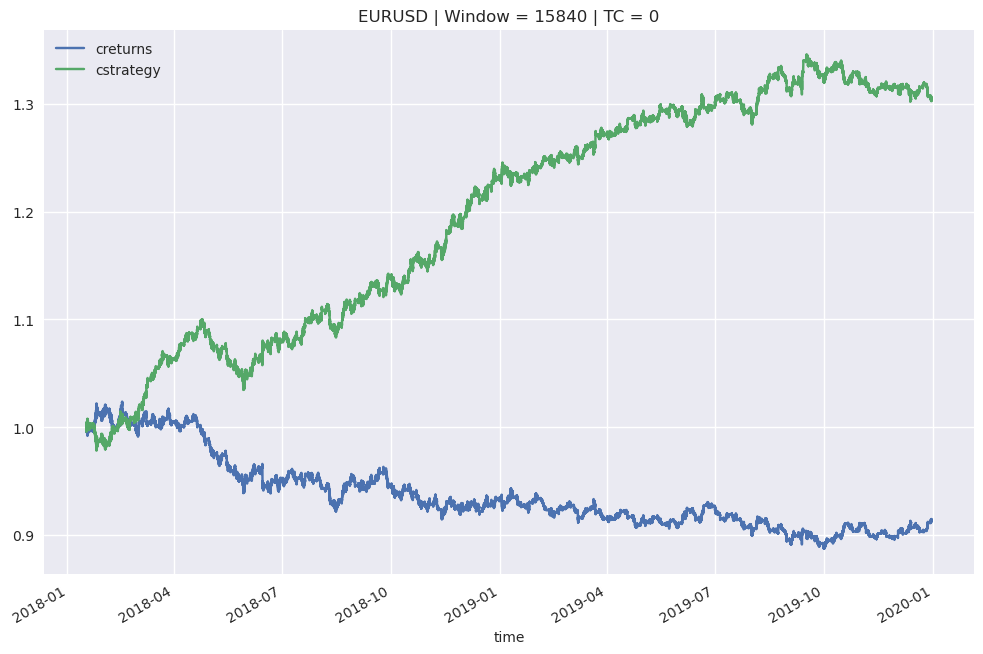

In [23]:
tester2.plot_results()

**Summary:**
- bar length (frequency/granularity): 1 minute
- decision/trading frequency: 1 minute
- decisions based on the performance of the most recent 264 hours (15,840 minutes)

__Conclusion:__
- Can we take advantage of the short-term volatility or is it just (patternless) random noise? __A: (Small) benefit__
- At least it doesn´t hurt us, right? __A: Correct__
- Best Contrarian Strategy based on 1 minute data should be at least as good as the best one based on 6h data? __A: Correct__

__Be careful, so far we ignored trading costs__!

## How Trading Strategies are impacted by Random Noise (with costs)

In [8]:
symbol = "EURUSD"
start = "2018-01-01"
end = "2019-12-31"
ptc = 0.00007

In [9]:
tester1 = ConBacktester(filepath = "intraday.csv", symbol = symbol, start = start, end = end, tc = ptc)
tester1

ConBacktester(symbol = EURUSD, start = 2018-01-01, end = 2019-12-31)

In [10]:
tester1.optimize_strategy((1, 1001, 1), metric = "Multiple")

Windows: 51 | Multiple: 1.262038
SIMPLE CONTRARIAN STRATEGY | INSTRUMENT = EURUSD | WINDOW = 51
----------------------------------------------------------------------------------------------------
PERFORMANCE MEASURES:


Multiple (Strategy):         1.262038
Multiple (Buy-and-Hold):     0.915401
--------------------------------------
Out-/Underperformance:       0.346637


CAGR:                        0.126996
Annualized Mean:             0.119772
Annualized Std:              0.059895
Sharpe Ratio:                1.999706
Sortino Ratio:               3.099553
Maximum Drawdown:            0.060965
Calmar Ratio:                2.083103
Max Drawdown Duration:       93 Days
Kelly Criterion:             33.85233


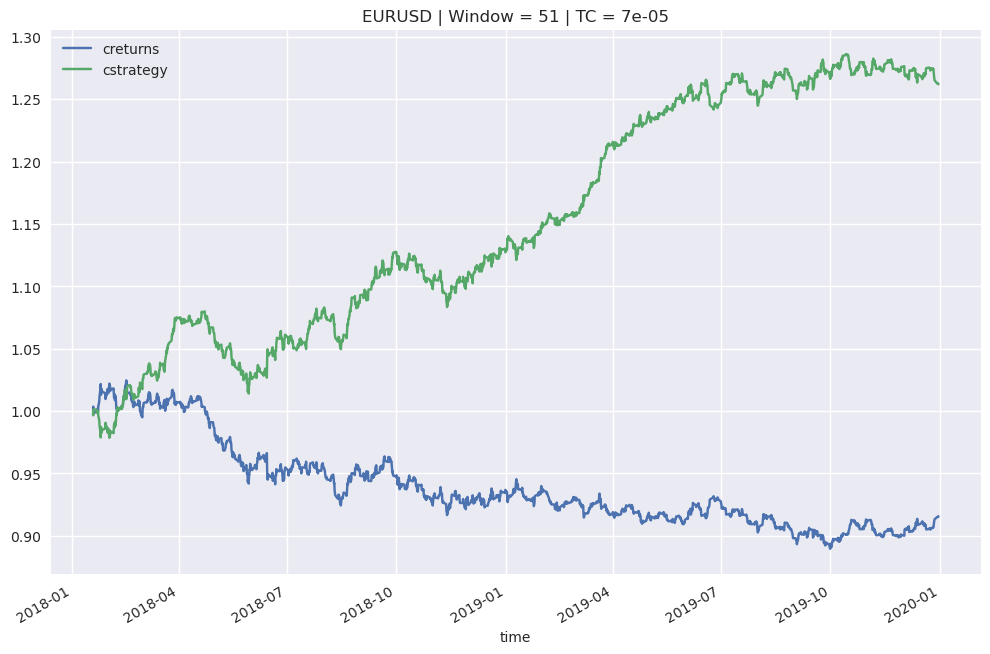

In [11]:
tester1.plot_results()

In [12]:
tester2 = ConBacktester(filepath = "one_minute.csv", symbol = symbol, start = start, end = end, tc = ptc)
tester2

ConBacktester(symbol = EURUSD, start = 2018-01-01, end = 2019-12-31)

In [13]:
window = 51
hours = 6
minutes = 60

In [14]:
tester2.test_strategy(window * hours * minutes)

SIMPLE CONTRARIAN STRATEGY | INSTRUMENT = EURUSD | WINDOW = 18360
----------------------------------------------------------------------------------------------------
PERFORMANCE MEASURES:


Multiple (Strategy):         0.866034
Multiple (Buy-and-Hold):     0.914767
--------------------------------------
Out-/Underperformance:       -0.048733


CAGR:                        -0.071224
Annualized Mean:             -0.074005
Annualized Std:              0.06759
Sharpe Ratio:                -1.094901
Sortino Ratio:               -1.549118
Maximum Drawdown:            0.164531
Calmar Ratio:                -0.43289
Max Drawdown Duration:       635 Days
Kelly Criterion:             -15.699168


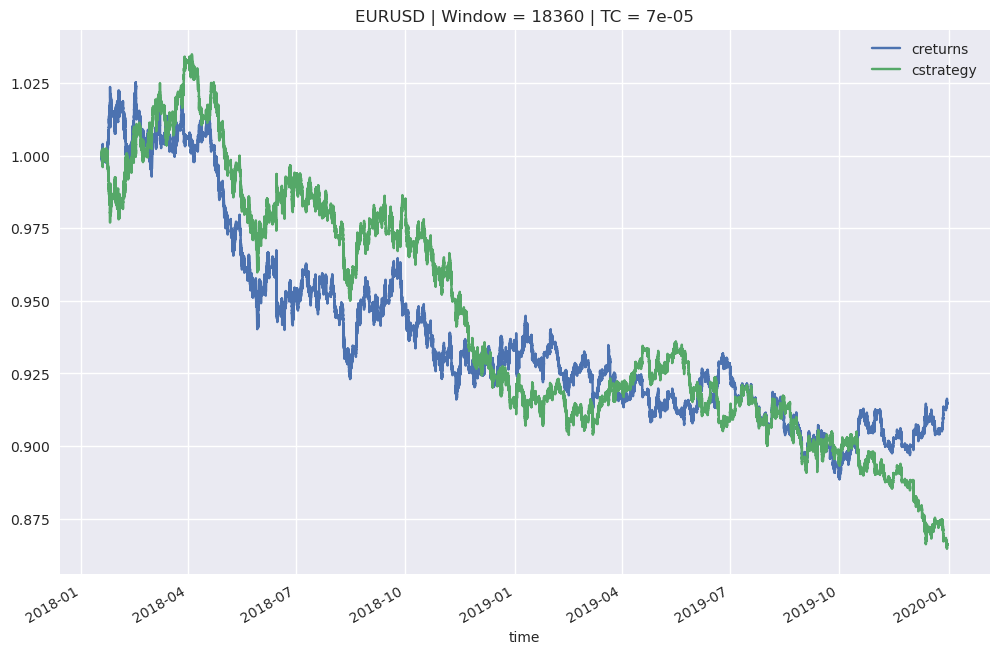

In [15]:
tester2.plot_results()

__Why is more granular strategy underperforming?__

- 1 minute Data (unsmoothed) has lots of __random noise__ (false/unprofitable trading signals) 
- leading to __excessive (and useless) trading__
- __additional trading costs are way higher__ than the additional (small) benefits.

In [16]:
tester1.results.trades.value_counts()

0.0    1876
2.0     142
Name: trades, dtype: int64

In [17]:
tester2.results.trades.value_counts()

0.0    716367
2.0      2816
Name: trades, dtype: int64

In [18]:
tester2.optimize_strategy((1*60*6, 1001*60*6, 1*60*6)) # try to find optimal strategy based on 1 minute data

Windows: 232200 | Multiple: 1.00127
SIMPLE CONTRARIAN STRATEGY | INSTRUMENT = EURUSD | WINDOW = 232200
----------------------------------------------------------------------------------------------------
PERFORMANCE MEASURES:


Multiple (Strategy):         1.00127
Multiple (Buy-and-Hold):     0.990705
--------------------------------------
Out-/Underperformance:       0.010565


CAGR:                        0.000924
Annualized Mean:             0.000929
Annualized Std:              0.061302
Sharpe Ratio:                0.015157
Sortino Ratio:               0.021505
Maximum Drawdown:            0.071229
Calmar Ratio:                0.012968
Max Drawdown Duration:       462 Days
Kelly Criterion:             0.74724


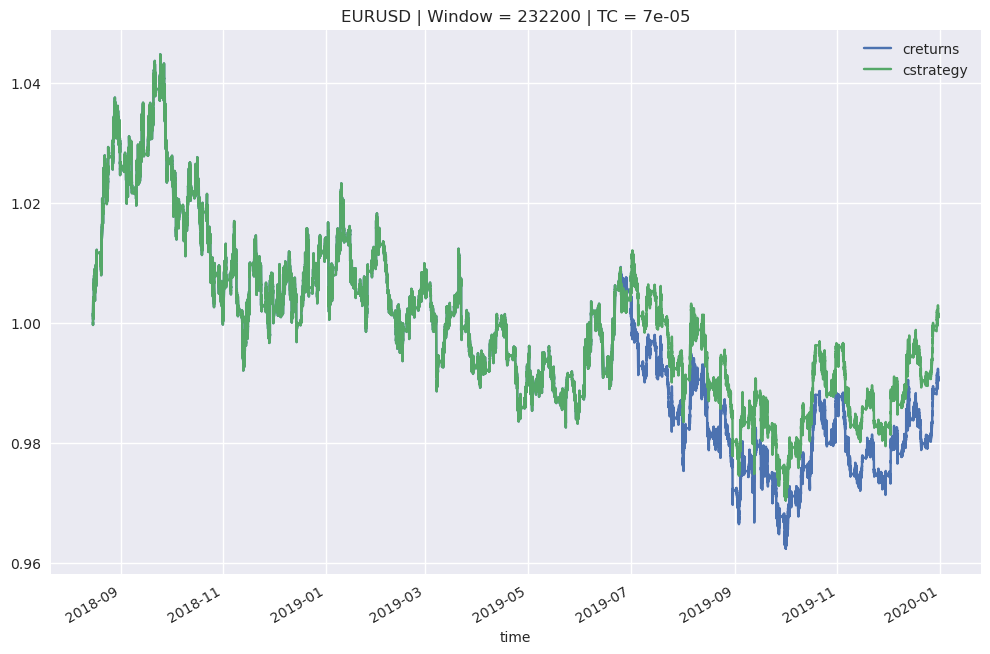

In [20]:
tester2.plot_results()

In [21]:
tester2.results.trades.value_counts()

0.0    505211
2.0       132
Name: trades, dtype: int64

__Conclusion:__
- there is __no chance to find (highly) profitable simple contrarian strategies with 1 minute data__.
- __Short term volatility__ is just (patternless) __random noise__ -> at least for the simple contrarian strategy
- __wrong__: the higher the data frequency the better for trading (more information is better than less) 
- there must be an __optimal frequency/granularity__ for the simple contrarian strategy and the given trading cost level

## Data Resampling/Smoothing and Backtesting

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("seaborn-v0_8")

In [20]:
symbol = "EURUSD"

In [21]:
data = pd.read_csv("one_minute.csv", parse_dates = ["time"], index_col = "time")
data

,EURUSD,GBPUSD,EURAUD
time,,,
2018-01-01 22:00:00,1.20071,1.35021,1.53836
2018-01-01 22:01:00,1.20068,1.35105,1.53829
2018-01-01 22:02:00,1.20073,1.35028,1.53834
2018-01-01 22:03:00,1.20072,1.35135,1.53833
2018-01-01 22:04:00,NaN,1.35098,NaN
...,...,...,...
2019-12-30 23:56:00,NaN,1.31136,1.59978
2019-12-30 23:57:00,1.12018,1.31126,1.60000
2019-12-30 23:58:00,NaN,1.31122,1.59994


In [22]:
data = data[symbol].to_frame().fillna(method = 'ffill')
data

,EURUSD
time,
2018-01-01 22:00:00,1.20071
2018-01-01 22:01:00,1.20068
2018-01-01 22:02:00,1.20073
2018-01-01 22:03:00,1.20072
2018-01-01 22:04:00,1.20072
...,...
2019-12-30 23:56:00,1.12018
2019-12-30 23:57:00,1.12018
2019-12-30 23:58:00,1.12018


In [23]:
data.rename(columns={symbol: 'price'}, inplace=True)
data

,price
time,
2018-01-01 22:00:00,1.20071
2018-01-01 22:01:00,1.20068
2018-01-01 22:02:00,1.20073
2018-01-01 22:03:00,1.20072
2018-01-01 22:04:00,1.20072
...,...
2019-12-30 23:56:00,1.12018
2019-12-30 23:57:00,1.12018
2019-12-30 23:58:00,1.12018


In [24]:
data["returns"] = np.log(data.price / data.price.shift(1))
data

,price,returns
time,,
2018-01-01 22:00:00,1.20071,NaN
2018-01-01 22:01:00,1.20068,-0.000025
2018-01-01 22:02:00,1.20073,0.000042
2018-01-01 22:03:00,1.20072,-0.000008
2018-01-01 22:04:00,1.20072,0.000000
...,...,...
2019-12-30 23:56:00,1.12018,0.000000
2019-12-30 23:57:00,1.12018,0.000000
2019-12-30 23:58:00,1.12018,0.000000


**Prepare data**

In [25]:
freq = 180
freq = "{}min".format(freq)
window = 100

In [26]:
resamp = data.price.to_frame().resample(freq).last().dropna().iloc[:-1]
resamp

,price
time,
2018-01-01 21:00:00,1.20108
2018-01-02 00:00:00,1.20096
2018-01-02 03:00:00,1.20245
2018-01-02 06:00:00,1.20450
2018-01-02 09:00:00,1.20594
...,...
2019-12-30 09:00:00,1.11916
2019-12-30 12:00:00,1.12058
2019-12-30 15:00:00,1.12107


- use last() to get a bar´s close price
- dropna() removes NaNs on weekends and bank holidays (resample() creates ALL 180min bars)
- the last bar is typically incomplete -> iloc[:-1]
- Index: It´s the starting time (open) of the bars

In [27]:
resamp["returns"] = np.log(resamp / resamp.shift(1))
resamp["roll_return"] = resamp["returns"].rolling(window).mean()
resamp

,price,returns,roll_return
time,,,
2018-01-01 21:00:00,1.20108,NaN,NaN
2018-01-02 00:00:00,1.20096,-0.000100,NaN
2018-01-02 03:00:00,1.20245,0.001240,NaN
2018-01-02 06:00:00,1.20450,0.001703,NaN
2018-01-02 09:00:00,1.20594,0.001195,NaN
...,...,...,...
2019-12-30 09:00:00,1.11916,-0.000482,0.000098
2019-12-30 12:00:00,1.12058,0.001268,0.000103
2019-12-30 15:00:00,1.12107,0.000437,0.000106


In [28]:
resamp["position"] = -np.sign(resamp["roll_return"])
resamp

,price,returns,roll_return,position
time,,,,
2018-01-01 21:00:00,1.20108,NaN,NaN,NaN
2018-01-02 00:00:00,1.20096,-0.000100,NaN,NaN
2018-01-02 03:00:00,1.20245,0.001240,NaN,NaN
2018-01-02 06:00:00,1.20450,0.001703,NaN,NaN
2018-01-02 09:00:00,1.20594,0.001195,NaN,NaN
...,...,...,...,...
2019-12-30 09:00:00,1.11916,-0.000482,0.000098,-1.0
2019-12-30 12:00:00,1.12058,0.001268,0.000103,-1.0
2019-12-30 15:00:00,1.12107,0.000437,0.000106,-1.0


In [29]:
resamp = resamp.dropna()
resamp

,price,returns,roll_return,position
time,,,,
2018-01-18 03:00:00,1.22070,0.001041,0.000162,-1.0
2018-01-18 06:00:00,1.22040,-0.000246,0.000161,-1.0
2018-01-18 09:00:00,1.22400,0.002946,0.000178,-1.0
2018-01-18 12:00:00,1.22606,0.001682,0.000177,-1.0
2018-01-18 15:00:00,1.22283,-0.002638,0.000139,-1.0
...,...,...,...,...
2019-12-30 09:00:00,1.11916,-0.000482,0.000098,-1.0
2019-12-30 12:00:00,1.12058,0.001268,0.000103,-1.0
2019-12-30 15:00:00,1.12107,0.000437,0.000106,-1.0


-> First Trade at __2018-01-18 06:00:00__ (short / -1) for the bar from 2018-01-18 06:00:00 until 2018-01-18 09:00:00

__Upsample__

__Goal: Copy the trading positions back into the 1 minute Dataset. ("upsampling")__

-> In the 1 minute Dataset, first Trade at __2018-01-18 06:00:00__ needs to be __indicated by the bar starting at 2018-01-18 05:59:00__

In [30]:
begin = "2018-01-18 05:59:00"
begin

'2018-01-18 05:59:00'

In [31]:
data

,price,returns
time,,
2018-01-01 22:00:00,1.20071,NaN
2018-01-01 22:01:00,1.20068,-0.000025
2018-01-01 22:02:00,1.20073,0.000042
2018-01-01 22:03:00,1.20072,-0.000008
2018-01-01 22:04:00,1.20072,0.000000
...,...,...
2019-12-30 23:56:00,1.12018,0.000000
2019-12-30 23:57:00,1.12018,0.000000
2019-12-30 23:58:00,1.12018,0.000000


In [32]:
data = data.loc[begin:].copy()
data

,price,returns
time,,
2018-01-18 05:59:00,1.22070,0.000156
2018-01-18 06:00:00,1.22059,-0.000090
2018-01-18 06:01:00,1.22065,0.000049
2018-01-18 06:02:00,1.22064,-0.000008
2018-01-18 06:03:00,1.22064,0.000000
...,...,...
2019-12-30 23:56:00,1.12018,0.000000
2019-12-30 23:57:00,1.12018,0.000000
2019-12-30 23:58:00,1.12018,0.000000


In [33]:
resamp

,price,returns,roll_return,position
time,,,,
2018-01-18 03:00:00,1.22070,0.001041,0.000162,-1.0
2018-01-18 06:00:00,1.22040,-0.000246,0.000161,-1.0
2018-01-18 09:00:00,1.22400,0.002946,0.000178,-1.0
2018-01-18 12:00:00,1.22606,0.001682,0.000177,-1.0
2018-01-18 15:00:00,1.22283,-0.002638,0.000139,-1.0
...,...,...,...,...
2019-12-30 09:00:00,1.11916,-0.000482,0.000098,-1.0
2019-12-30 12:00:00,1.12058,0.001268,0.000103,-1.0
2019-12-30 15:00:00,1.12107,0.000437,0.000106,-1.0


In [34]:
resamp.position.shift()

time
2018-01-18 03:00:00    NaN
2018-01-18 06:00:00   -1.0
2018-01-18 09:00:00   -1.0
2018-01-18 12:00:00   -1.0
2018-01-18 15:00:00   -1.0
                      ... 
2019-12-30 09:00:00   -1.0
2019-12-30 12:00:00   -1.0
2019-12-30 15:00:00   -1.0
2019-12-30 18:00:00   -1.0
2019-12-30 21:00:00   -1.0
Name: position, Length: 4082, dtype: float64

In [35]:
data["position"] = resamp.position.shift()
data

,price,returns,position
time,,,
2018-01-18 05:59:00,1.22070,0.000156,NaN
2018-01-18 06:00:00,1.22059,-0.000090,-1.0
2018-01-18 06:01:00,1.22065,0.000049,NaN
2018-01-18 06:02:00,1.22064,-0.000008,NaN
2018-01-18 06:03:00,1.22064,0.000000,NaN
...,...,...,...
2019-12-30 23:56:00,1.12018,0.000000,NaN
2019-12-30 23:57:00,1.12018,0.000000,NaN
2019-12-30 23:58:00,1.12018,0.000000,NaN


In [37]:
data.position = data.position.shift(-1).ffill() # shift back one bar and then forward fill for the next 180 minutes
data

,price,returns,position
time,,,
2018-01-18 05:59:00,1.22070,0.000156,-1.0
2018-01-18 06:00:00,1.22059,-0.000090,-1.0
2018-01-18 06:01:00,1.22065,0.000049,-1.0
2018-01-18 06:02:00,1.22064,-0.000008,-1.0
2018-01-18 06:03:00,1.22064,0.000000,-1.0
...,...,...,...
2019-12-30 23:56:00,1.12018,0.000000,-1.0
2019-12-30 23:57:00,1.12018,0.000000,-1.0
2019-12-30 23:58:00,1.12018,0.000000,-1.0


**Backtest**

In [38]:
data["strategy"] = data["position"].shift(1) * data["returns"]
data

,price,returns,position,strategy
time,,,,
2018-01-18 05:59:00,1.22070,0.000156,-1.0,NaN
2018-01-18 06:00:00,1.22059,-0.000090,-1.0,0.000090
2018-01-18 06:01:00,1.22065,0.000049,-1.0,-0.000049
2018-01-18 06:02:00,1.22064,-0.000008,-1.0,0.000008
2018-01-18 06:03:00,1.22064,0.000000,-1.0,-0.000000
...,...,...,...,...
2019-12-30 23:56:00,1.12018,0.000000,-1.0,-0.000000
2019-12-30 23:57:00,1.12018,0.000000,-1.0,-0.000000
2019-12-30 23:58:00,1.12018,0.000000,-1.0,-0.000000


In [39]:
ptc = 0.00007

In [41]:
data["trades"] = data.position.diff().fillna(0).abs()
data.strategy = data.strategy - data.trades * ptc
data

,price,returns,position,strategy,trades
time,,,,,
2018-01-18 05:59:00,1.22070,0.000156,-1.0,NaN,0.0
2018-01-18 06:00:00,1.22059,-0.000090,-1.0,0.000090,0.0
2018-01-18 06:01:00,1.22065,0.000049,-1.0,-0.000049,0.0
2018-01-18 06:02:00,1.22064,-0.000008,-1.0,0.000008,0.0
2018-01-18 06:03:00,1.22064,0.000000,-1.0,-0.000000,0.0
...,...,...,...,...,...
2019-12-30 23:56:00,1.12018,0.000000,-1.0,-0.000000,0.0
2019-12-30 23:57:00,1.12018,0.000000,-1.0,-0.000000,0.0
2019-12-30 23:58:00,1.12018,0.000000,-1.0,-0.000000,0.0


In [42]:
data["creturns"] = data["returns"].cumsum().apply(np.exp)
data["cstrategy"] = data["strategy"].cumsum().apply(np.exp)

In [43]:
data.dropna()

,price,returns,position,strategy,trades,creturns,cstrategy
time,,,,,,,
2018-01-18 06:00:00,1.22059,-0.000090,-1.0,0.000090,0.0,1.000066,1.000090
2018-01-18 06:01:00,1.22065,0.000049,-1.0,-0.000049,0.0,1.000115,1.000041
2018-01-18 06:02:00,1.22064,-0.000008,-1.0,0.000008,0.0,1.000107,1.000049
2018-01-18 06:03:00,1.22064,0.000000,-1.0,-0.000000,0.0,1.000107,1.000049
2018-01-18 06:04:00,1.22039,-0.000205,-1.0,0.000205,0.0,0.999902,1.000254
...,...,...,...,...,...,...,...
2019-12-30 23:56:00,1.12018,0.000000,-1.0,-0.000000,0.0,0.917797,1.132943
2019-12-30 23:57:00,1.12018,0.000000,-1.0,-0.000000,0.0,0.917797,1.132943
2019-12-30 23:58:00,1.12018,0.000000,-1.0,-0.000000,0.0,0.917797,1.132943


<Axes: xlabel='time'>

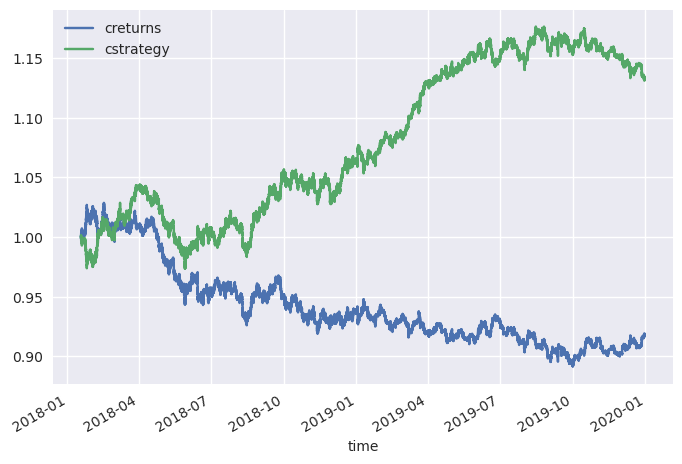

In [44]:
data[["creturns", "cstrategy"]].plot()

In [45]:
data.trades.value_counts()

0.0    719602
2.0       230
Name: trades, dtype: int64